In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [3]:
# Global Variables
RAW_DATASET_PATH = "/content/drive/MyDrive/machine_learning/raw_dataset"
SPLIT_DATASET_PATH = "/content/drive/MyDrive/machine_learning/split_dataset"
TRAIN_PATH = os.path.join(SPLIT_DATASET_PATH, 'train')
VAL_PATH = os.path.join(SPLIT_DATASET_PATH, 'val')
SPICES_LIST = os.listdir(RAW_DATASET_PATH)
NUM_OF_SPICES = len(SPICES_LIST)

print('Spices total:', NUM_OF_SPICES)


Spices total: 25


In [4]:
from tensorflow.keras.utils import image_dataset_from_directory as IMFD

# Constants
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
IMAGE_SIZE = (384, 384)
SEED = 314

# Create train dataset
train_dataset = IMFD(
    TRAIN_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

# Create validation dataset
val_dataset = IMFD(
    VAL_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

# Get class names
spices_names = train_dataset.class_names
print('\nClass Names:\n{}'.format(spices_names))


Found 1776 files belonging to 25 classes.
Found 764 files belonging to 25 classes.

Class Names:
['adas_bintang', 'andaliman', 'asam_jawa', 'bawang_merah', 'bawang_putih', 'biji_adas', 'biji_ketumbar', 'cabai', 'cengkeh', 'daun_ketumbar', 'daun_salam', 'jahe', 'kapulaga', 'kayu_manis', 'kayu_secang', 'kemiri', 'kencur', 'kunyit', 'lada', 'lengkuas', 'pala', 'serai', 'temulawak', 'vanili', 'wijen']


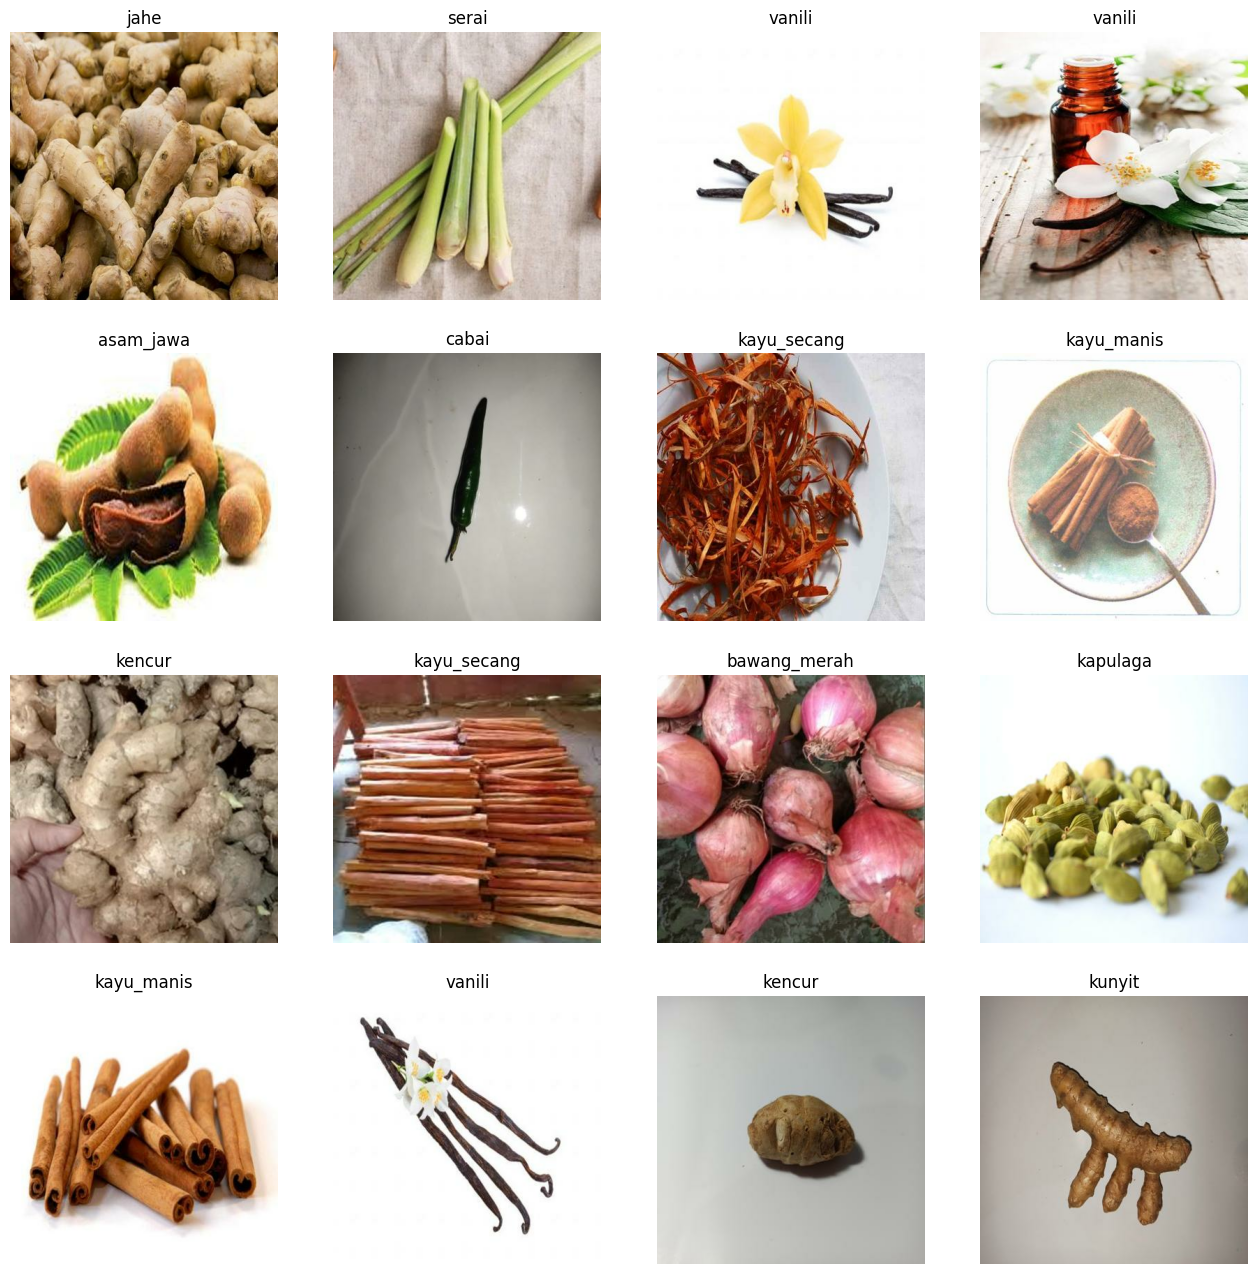

In [5]:
def plot_dataset_batch_images(data_generator, class_names):
    plt.figure(figsize=(16, 16))

    # Retrieve a batch of images and labels from the generator
    for images, labels in data_generator.take(1):
        for i in range(16):  # Adjust according to BATCH_SIZE
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            # Get the class index using one-hot encoding
            class_index = np.argmax(labels[i])

            # Display class name as title
            plt.title(class_names[class_index])
            plt.axis("off")

# Use the function with your dataset and class names
plot_dataset_batch_images(train_dataset, spices_names)

In [6]:
# Check Shape per batch
for images, labels in train_dataset.take(1):  # Iterate through the first batch in the training dataset
    print('Batch Image Shape:', images.shape)
    print('Batch Labels Shape:', labels.shape)
    break

Batch Image Shape: (32, 384, 384, 3)
Batch Labels Shape: (32, 25)


In [7]:
from tensorflow import keras
# Preprocessing Sequential Layers
rescale_layer = tf.keras.Sequential([
    keras.layers.Rescaling(1./255)
])

augmentation_layer = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(
        (-0.2, 0.2),
        fill_mode='reflect',
        interpolation='bilinear'
    ),
    keras.layers.RandomTranslation(
        (-0.15, 0.15),
        (-0.15, 0.15),
        fill_mode='reflect',
        interpolation='bilinear'
    ),
])

def preprocess_dataset(dataset, augment=False):
    # Rescale all datasets
    dataset = dataset.map(lambda x, y: (rescale_layer(x), y))

    # Data augmentation only on the training set.
    if augment:
        dataset = dataset.map(lambda x, y: (augmentation_layer(x, training=True), y))

    return dataset

train_ds = preprocess_dataset(train_dataset, augment=True)
val_ds = preprocess_dataset(val_dataset)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

# Base Model
input_shape = (384, 384, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    include_preprocessing=False
)
base_model.trainable = False

# Functional API for Keras Model Building
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(640, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(320, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_OF_SPICES, activation='softmax')(x)

# Create the final model using Functional API
model = tf.keras.Model(inputs, outputs)

# Display the summary of the final model
model.summary()

82420632/82420632 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, 12, 12, 1280)      20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 640)               819840    
                                                                 
 dropout (Dropout)           (None, 640)               0         
                                                              

In [9]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.94):
            self.model.stop_training = True

callbacks = myCallback()

In [11]:
EPOCHS = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/100
56/56 [==============================] - 261s 4s/step - loss: 3.0619 - accuracy: 0.1357 - val_loss: 2.6491 - val_accuracy: 0.5353
Epoch 2/100
56/56 [==============================] - 79s 1s/step - loss: 2.4756 - accuracy: 0.4251 - val_loss: 1.9311 - val_accuracy: 0.6872
Epoch 3/100
56/56 [==============================] - 79s 1s/step - loss: 1.8479 - accuracy: 0.5985 - val_loss: 1.2440 - val_accuracy: 0.7906
Epoch 4/100
56/56 [==============================] - 84s 1s/step - loss: 1.3258 - accuracy: 0.7066 - val_loss: 0.8238 - val_accuracy: 0.8429
Epoch 5/100
56/56 [==============================] - 80s 1s/step - loss: 1.0190 - accuracy: 0.7506 - val_loss: 0.6183 - val_accuracy: 0.8599
Epoch 6/100
56/56 [==============================] - 80s 1s/step - loss: 0.8629 - accuracy: 0.7787 - val_loss: 0.5057 - val_accuracy: 0.8783
Epoch 7/100
56/56 [==============================] - 82s 1s/step - loss: 0.6999 - accuracy: 0.8226 - val_loss: 0.4327 - val_accuracy: 0.8979
Epoch 8/100


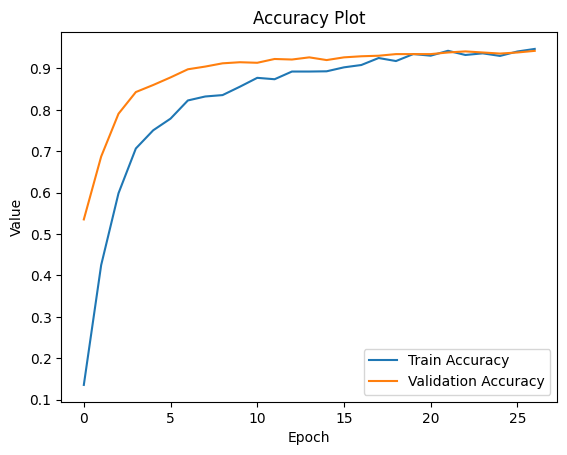

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

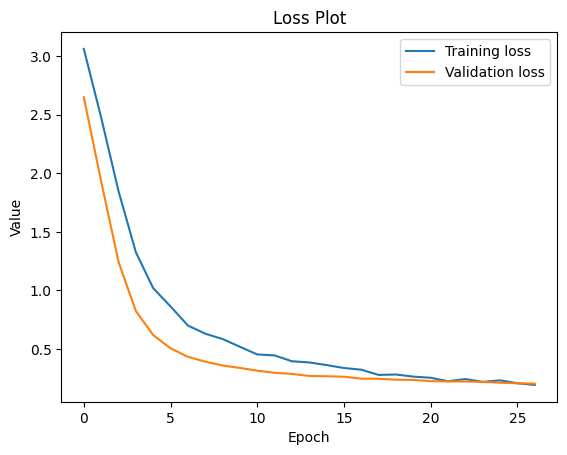

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label ='Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [33]:
from PIL import Image
from numpy import asarray

def preprocess_image_as_array(path, show_output):
    im = Image.open(path).convert('RGB')
    im = im.resize((384, 384))

    plt.figure(figsize=(8, 8))
    plt.imshow(im)
    plt.axis('off')

    image_as_array = np.expand_dims(asarray(im), axis=0)
    scaled_image_as_array = np.true_divide(image_as_array, 255)

    if show_output:
        print('Image {} completed process.'.format(path))
    return scaled_image_as_array

def preprocess_and_predict(image_path, show_output=True):
    image_as_array = preprocess_image_as_array(image_path, show_output)
    pred = model.predict(image_as_array)
    sorted_ranks = np.flip(np.argsort(pred[0]))

    if show_output:
        rank = 1
        print('Spices Predict:')
        highest_rank = sorted_ranks[0]
        print('Result: {:16} \nAccuracy: {:.3f}'.format(spices_names[highest_rank], pred[0][highest_rank]))
    print('')

In [15]:
# Try out model with uploaded images
from google.colab import files
uploaded = files.upload()

Saving images.jpeg to images.jpeg


Image /content/images.jpeg completed process.
1/1 [==============================] - 0s 33ms/step
Spices Predict:
Result: cengkeh          
Accuracy: 0.999



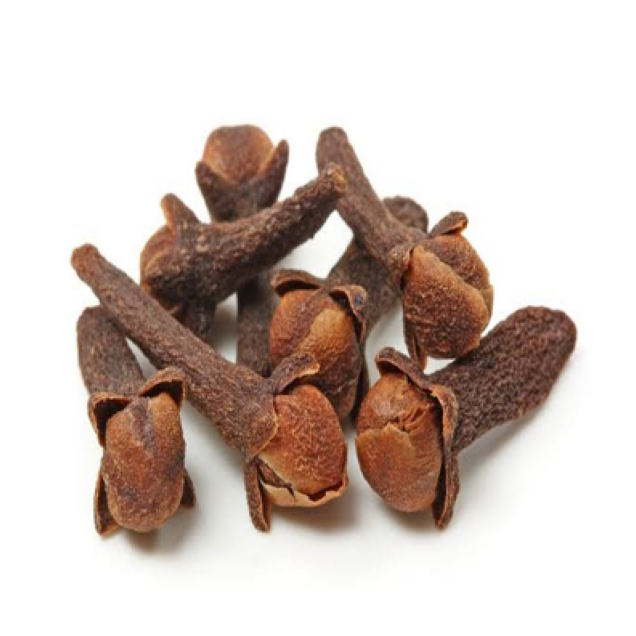

In [34]:
preprocess_and_predict('/content/images.jpeg', show_output=True)

In [19]:
# Save the model
SAVED_MODEL = "spices_saved_model"
tf.saved_model.save(model, SAVED_MODEL)

In [20]:
model.save('/content/drive/MyDrive/machine_learning/model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
tflite_model = tf.keras.models.load_model("/content/drive/MyDrive/machine_learning/model/model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_save = converter.convert()
open("/content/drive/MyDrive/machine_learning/model/model.tflite", "wb").write(tflite_save)

23006912